In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
train_data = pd.read_csv('telecom_train.csv')
train_df = pd.DataFrame(data=train_data)

# get attributes series
attributes = train_df.columns
print(attributes)

Index(['Customer ID', 'Gender', 'Age', 'Married', 'Number of Dependents',
       'City', 'Zip Code', 'Latitude', 'Longitude', 'Number of Referrals',
       'Tenure in Months', 'Offer', 'Phone Service',
       'Avg Monthly Long Distance Charges', 'Multiple Lines',
       'Internet Service', 'Internet Type', 'Avg Monthly GB Download',
       'Online Security', 'Online Backup', 'Device Protection Plan',
       'Premium Tech Support', 'Streaming TV', 'Streaming Movies',
       'Streaming Music', 'Unlimited Data', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charge', 'Total Charges', 'Total Refunds',
       'Total Extra Data Charges', 'Total Long Distance Charges',
       'Total Revenue', 'Customer Status', 'Churn Category', 'Churn Reason'],
      dtype='object')


In [5]:
# show first 5 rows
pd.set_option('display.max_columns', None)
train_df.head(5)

,Customer ID,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,Tenure in Months,Offer,Phone Service,Avg Monthly Long Distance Charges,Multiple Lines,Internet Service,Internet Type,Avg Monthly GB Download,Online Security,Online Backup,Device Protection Plan,Premium Tech Support,Streaming TV,Streaming Movies,Streaming Music,Unlimited Data,Contract,Paperless Billing,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,9,NaN,Yes,42.39,No,Yes,Cable,16.0,No,Yes,No,Yes,Yes,No,No,Yes,One Year,Yes,Credit Card,65.6,593.30,0.00,0,381.51,974.81,Stayed,NaN,NaN
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,9,NaN,Yes,10.69,Yes,Yes,Cable,10.0,No,No,No,No,No,Yes,Yes,No,Month-to-Month,No,Credit Card,-4.0,542.40,38.33,10,96.21,610.28,Stayed,NaN,NaN
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,4,Offer E,Yes,33.65,No,Yes,Fiber Optic,30.0,No,No,Yes,No,No,No,No,Yes,Month-to-Month,Yes,Bank Withdrawal,73.9,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,13,Offer D,Yes,27.82,No,Yes,Fiber Optic,4.0,No,Yes,Yes,No,Yes,Yes,No,Yes,Month-to-Month,Yes,Bank Withdrawal,98.0,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,3,NaN,Yes,7.38,No,Yes,Fiber Optic,11.0,No,No,No,Yes,Yes,No,No,Yes,Month-to-Month,Yes,Credit Card,83.9,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability


## Phần 1: Giới thiệu
Giữ chân khách hàng là yếu tố then chốt cho sự thành công của một công ty, đặc biệt trong một ngành cạnh tranh như dịch vụ viễn thông. Thu hút khách hàng mới không chỉ khó khăn hơn mà còn tốn kém hơn nhiều so với việc duy trì mối quan hệ với khách hàng hiện tại. Trong sổ tay này, chúng tôi sẽ dự đoán hành vi để giữ chân khách hàng tại một nhà cung cấp dịch vụ viễn thông. Trước tiên, chúng tôi sẽ sử dụng phân tích dữ liệu thăm dò để hiểu các mối quan hệ giữa các đặc điểm và biến mục tiêu, và xác định các yếu tố có ảnh hưởng trong việc dự đoán sự rời bỏ của khách hàng. Sử dụng những đặc điểm này, chúng tôi sẽ phát triển một mô hình dự đoán để giúp công ty giảm tỷ lệ rời bỏ một cách chủ động và sử dụng những thông tin từ mô hình để củng cố các chiến lược giữ chân khách hàng.

## Phần 2: Hiểu dữ liệu
Dữ liệu từ tập training bao gồm 5500 bản ghi với hai mươi thuộc tính được chia thành hai loại: dữ liệu nhân khẩu học của khách hàng và thông tin liên quan đến tài khoản dịch vụ không dây của họ. Các đặc điểm nhân khẩu học bao gồm giới tính của khách hàng, liệu họ có đối tác, người phụ thuộc, và trên 65 tuổi hay không. Các đặc điểm liên quan đến thông tin tài khoản bao gồm thời gian khách hàng đã gắn bó với Telco, chi phí hàng tháng và tổng chi phí của họ, hợp đồng của từng khách hàng (theo tháng, một năm, hoặc hai năm), và loại dịch vụ điện thoại, internet, và TV mà họ có. Biến mục tiêu của chúng tôi cho nghiên cứu này là Churn, một chỉ số nhị phân biểu thị liệu khách hàng có rời đi trong tháng trước hay không.


### Trực quan hoá các thuộc tính phân loại có liên quan đến khả năng rời bỏ dịch vụ

Tỉ lệ khách hàng rời bỏ nhà mạng hiện nay đang là 26.95%

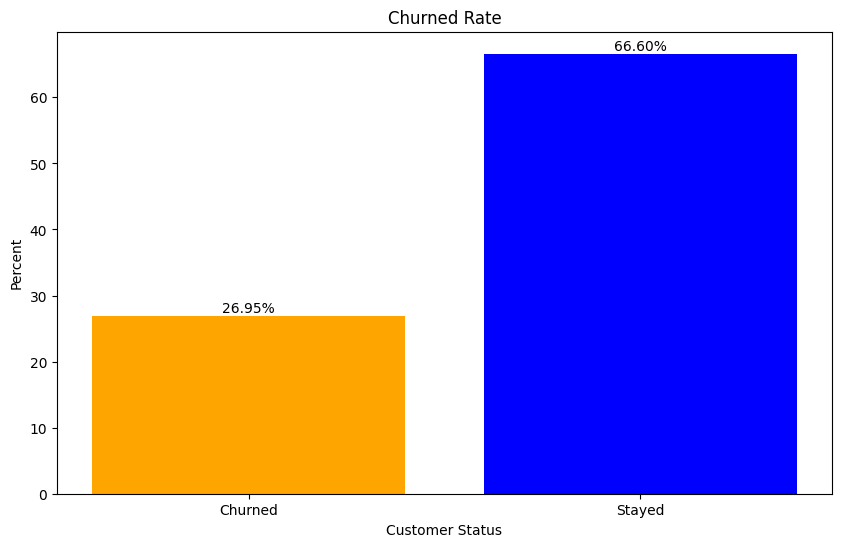

In [6]:
# show churned rate and stayed rate
churned_rate = train_df[train_df['Customer Status'] == 'Churned'].shape[0] / train_df.shape[0] * 100
stayed_rate = train_df[train_df['Customer Status'] == 'Stayed'].shape[0] / train_df.shape[0] * 100

plt.figure(figsize=(10, 6))
bars = plt.bar(['Churned', 'Stayed'], [churned_rate, stayed_rate], color=['orange', 'blue'])
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}%', ha='center', va='bottom')
plt.title('Churned Rate')
plt.xlabel('Customer Status')
plt.ylabel('Percent')
plt.show()

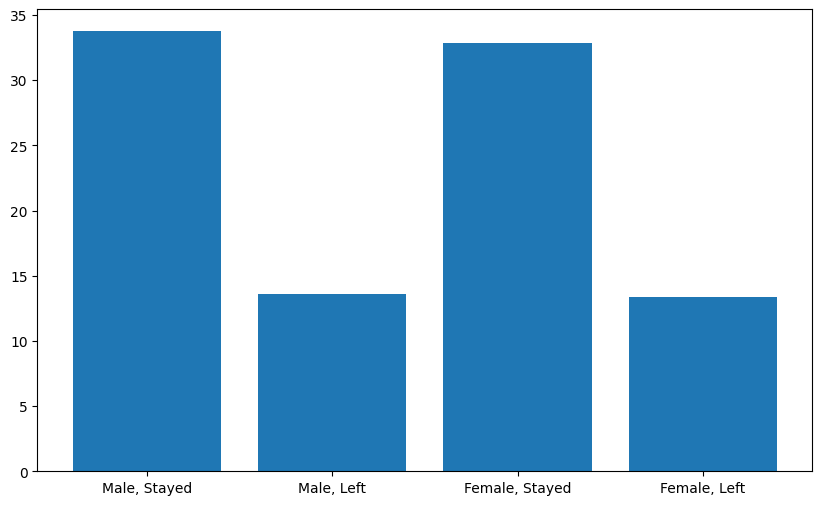

In [7]:
# proporion between male and female customers who stayed and left
male_stayed = train_df[(train_df['Customer Status'] == 'Stayed') & (train_df['Gender'] == 'Male')].shape[0] / train_df.shape[0] * 100
male_left = train_df[(train_df['Customer Status'] == 'Churned') & (train_df['Gender'] == 'Male')].shape[0] / train_df.shape[0] * 100
female_stayed = train_df[(train_df['Customer Status'] == 'Stayed') & (train_df['Gender'] == 'Female')].shape[0] / train_df.shape[0] * 100
female_left = train_df[(train_df['Customer Status'] == 'Churned') & (train_df['Gender'] == 'Female')].shape[0] / train_df.shape[0] * 100

plt.figure(figsize=(10, 6))
bars = plt.bar(['Male, Stayed', 'Male, Left', 'Female, Stayed', 'Female, Left'], [male_stayed, male_left, female_stayed, female_left])

### 2.1: Thời gian gắn bó trung bình của khách hàng và khoản tiền phải đóng mỗi tháng

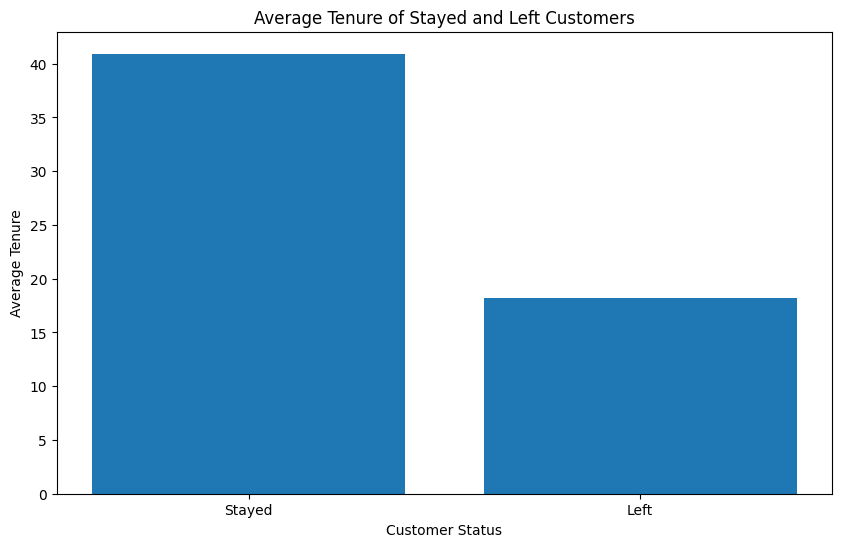

In [8]:
# find the number of stayed and left customers
stayed_customers = train_df[train_df['Customer Status'] == 'Stayed']
left_customers = train_df[train_df['Customer Status'] == 'Churned']

# calculate average tenure of stayed and left customers
stayed_tenure = stayed_customers['Tenure in Months'].mean()
left_tenure = left_customers['Tenure in Months'].mean()

plt.figure(figsize=(10, 6))
plt.bar(['Stayed', 'Left'], [stayed_tenure, left_tenure])
plt.title('Average Tenure of Stayed and Left Customers')
plt.xlabel('Customer Status')
plt.ylabel('Average Tenure')
plt.show()

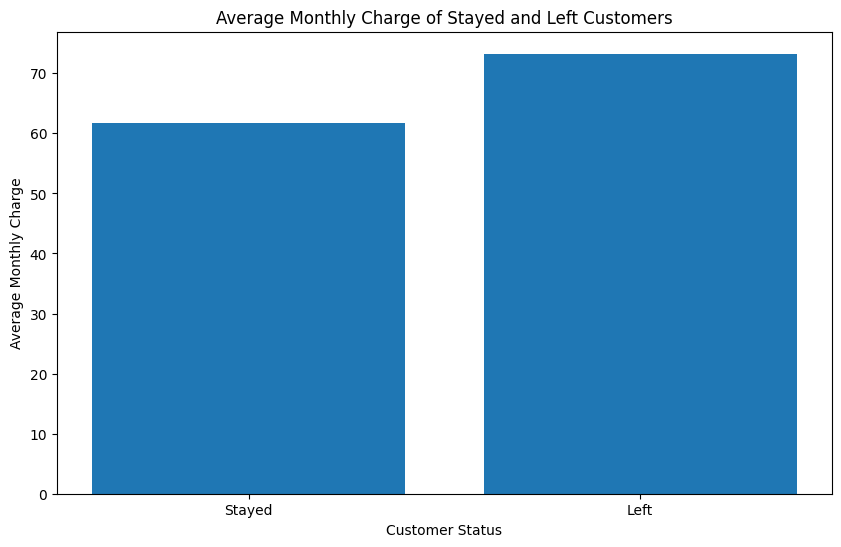

In [9]:
# find average monthly charge of stayed and left customers
stayed_monthly_charge = stayed_customers['Monthly Charge'].mean()
left_monthly_charge = left_customers['Monthly Charge'].mean()

plt.figure(figsize=(10, 6))
plt.bar(['Stayed', 'Left'], [stayed_monthly_charge, left_monthly_charge])
plt.title('Average Monthly Charge of Stayed and Left Customers')
plt.xlabel('Customer Status')
plt.ylabel('Average Monthly Charge')
plt.show()

### 2.2. Phân tích những biến có liên quan với tỉ lệ rời bỏ khách hàng

Thời gian gắn bó trung bình của khách hàng: Biểu đồ cho thấy thời gian gắn bó trung bình của những khách hàng ở lại là 42 tháng trong khi thời gian gắn bó trung bình của khách hàng rời bỏ là 10 tháng. Trong số những vị khách rời bỏ, có những trường hợp đã gắn bó hơn 70 tháng

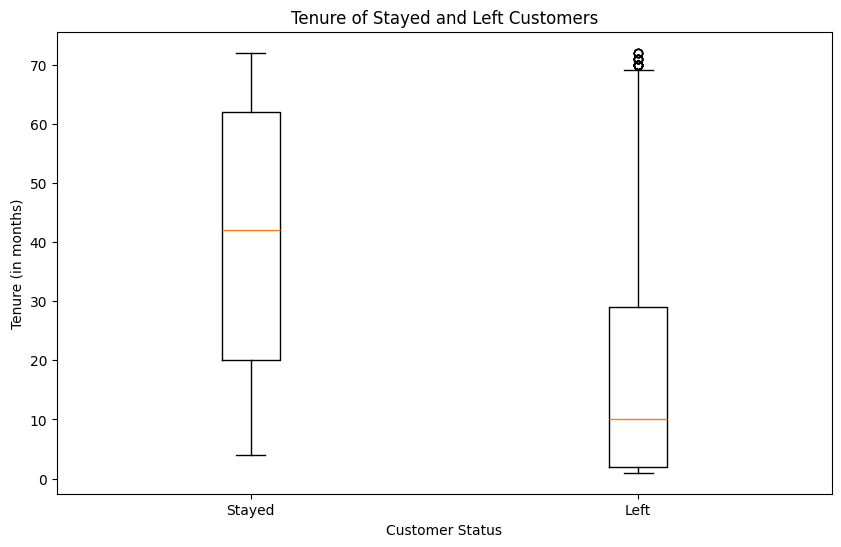

In [10]:
# draw boxplot of tenure of stayed and left customers
plt.figure(figsize=(10, 6))
plt.boxplot([stayed_customers['Tenure in Months'], left_customers['Tenure in Months']], tick_labels=['Stayed', 'Left'])
plt.title('Tenure of Stayed and Left Customers')
plt.xlabel('Customer Status')
plt.ylabel('Tenure (in months)')
plt.show()

Khoản tiền đóng mỗi tháng: Khoản tiền đóng mỗi tháng của nhóm khách ở lại có median là 67, trong khi nhóm rời bỏ có median là 80.

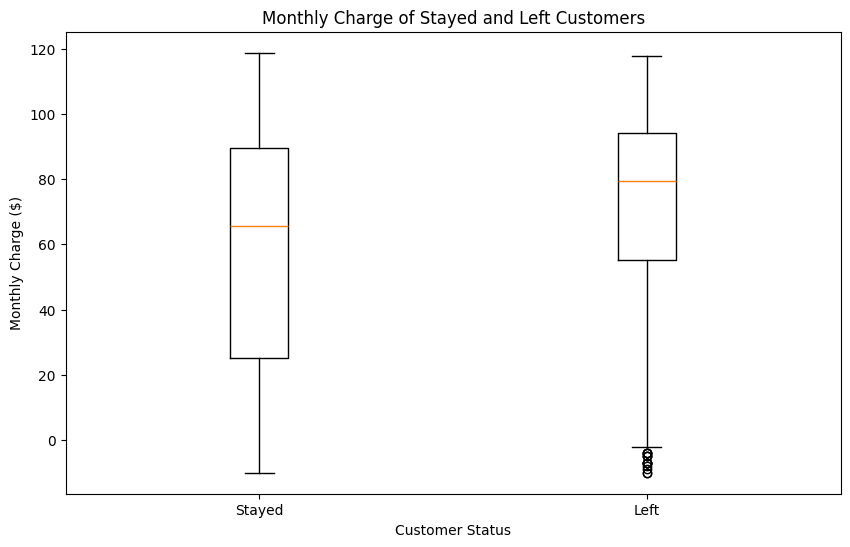

In [11]:
# draw boxplot of monthly charge of stayed and left customers
plt.figure(figsize=(10, 6))
plt.boxplot([stayed_customers['Monthly Charge'], left_customers['Monthly Charge']], tick_labels=['Stayed', 'Left'])
plt.title('Monthly Charge of Stayed and Left Customers')
plt.xlabel('Customer Status')
plt.ylabel('Monthly Charge ($)')
plt.show()

Tổng tiền đóng: Tổng tiền đã đóng của nhóm ở lại có median là 2000 trong khi tổng tiền đóng của nhóm rời đi là 1300.

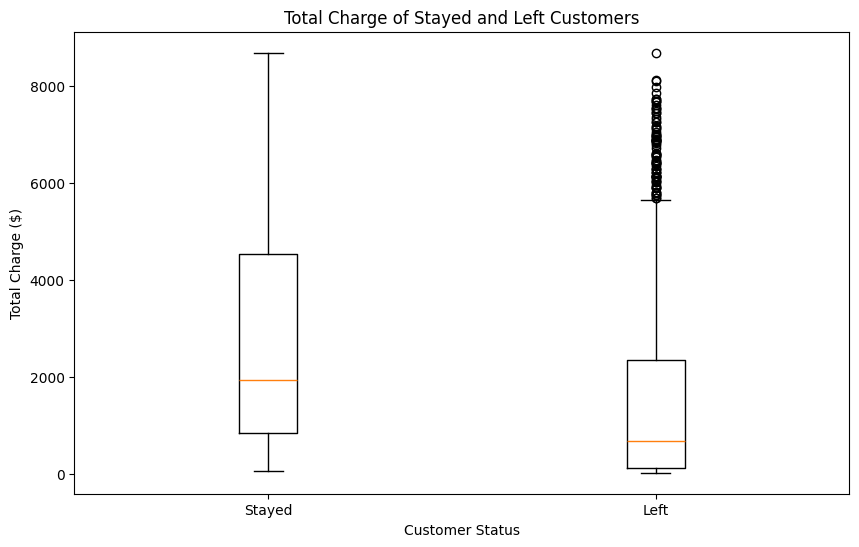

In [12]:
# boxplot of total charge of stayed and left customers
plt.figure(figsize=(10, 6))
plt.boxplot([stayed_customers['Total Charges'], left_customers['Total Charges']], tick_labels=['Stayed', 'Left'])
plt.title('Total Charge of Stayed and Left Customers')
plt.xlabel('Customer Status')
plt.ylabel('Total Charge ($)')
plt.show()

### Tương quan giữa 3 biến

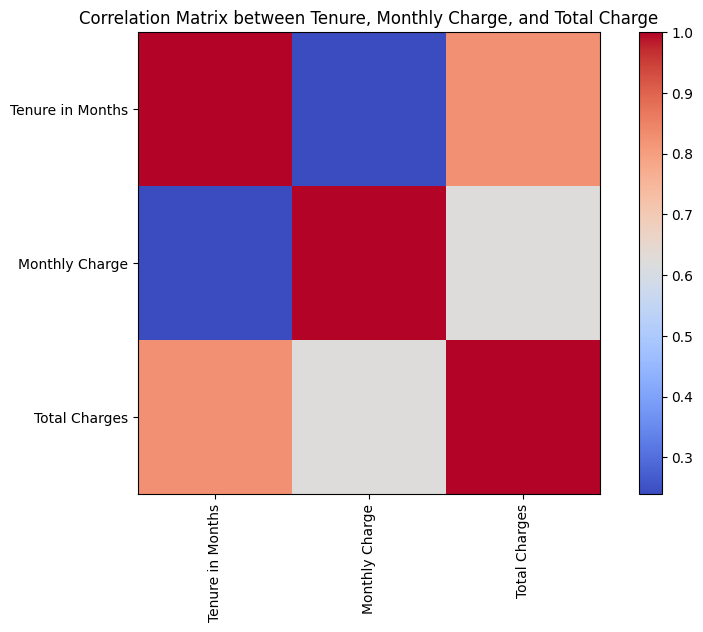

In [13]:
# correlation matrix between tenure, monthly charge, and total charge
correlation_matrix = train_df[['Tenure in Months', 'Monthly Charge', 'Total Charges']].corr()
plt.figure(figsize=(10, 6))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.title('Correlation Matrix between Tenure, Monthly Charge, and Total Charge')
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.show()

## Phần 4: Phân lớp

In [14]:
def expected_information(D):
    """
    Calculate the expected information (entropy) needed to classify a tuple in D.
    
    :param D: A pandas Series or list of class labels
    :return: The expected information (entropy) value
    """

    if not isinstance(D, pd.Series):
        D = pd.Series(D)
    
    probabilities = D.value_counts(normalize=True)

    entropy = -np.sum(probabilities * np.log2(probabilities))

    return entropy

def information_gain(data, target_attribute, split_attribute):
    """
    Calculate the information gain of a split.
    
    :param data: A pandas DataFrame
    :param target_attribute: The name of target attribute (class label)
    :param split_attribute: The attribute to split on
    :return: The information gain
    """

    # Calculate the entropy of the target attribute
    target_attribute = expected_information(data[target_attribute])

    # Calculate the entropy after split
    split_attribute = 0
    for value in data[split_attribute].unique():
        subset = data[data[split_attribute] == value]
        weight = len(subset) / len(data)
        split_attribute += weight * expected_information(subset[target_attribute])
    
    # Calculate the information gain
    information_gain = target_attribute - split_attribute

    return information_gain

def filter_attribute(data, target_attribute):
    """
    Filter attributes based exclude patterns.
    
    :param data: A pandas DataFrame containing the dataset
    :param target_attribute: The name of the target attribute (class label)
    :return: List of attributes to keep
    """

    # zip code: too granular and may lead to overfitting, city is more suitable
    # latitude and longitude: too specific and may lead to overfitting
    # total charges: derived attribute
    # total revenue: derived attribute
    exclude_patterns = ['id', 'zip', 'latitude', 'longitude', 'total charges', 
                        'total revenue', 'churn category', 'churn reason']
    
    attributes_to_keep = []

    for attribute in attributes:
        if attribute == target_attribute:
            continue

        if any(pattern in attribute.lower() for pattern in exclude_patterns):
            continue

        attributes_to_keep.append(attribute)

    return attributes_to_keep

def select_attribute(attribute_list):
    """
    Select an attribute to split on.
    
    :param attribute_list: List of attributes to select from
    :return: The name of the selected attribute
    """
    max = 0
    selected_attribute = ''

    for attribute in attribute_list:
        gain = information_gain(train_df, 'Customer Status', attribute)
        if gain > max:
            max = gain
            selected_attribute = attribute

    return selected_attribute

In [15]:
def gini_index(D):
    """
    Calculate the gini index of data partition D.
    
    :param D: A pandas Series or list of class labels
    :return: The gini index
    """

    if not isinstance(D, pd.Series):
        D = pd.Series(D)
    
    probabilities = D.value_counts(normalize=True)

    gini = 1 - np.sum(probabilities**2)

    return gini

def find_best_split(data, target_attribute, split_attribute):
    """
    Find the best binary split for a given attribute.
    
    :param data: A pandas DataFrame
    :param target_attribute: The name of target attribute (class label)
    :param split_attribute: The attribute to split on
    :return: The best split value and corresponding Gini gain
    """
    best_gain = 0
    best_split = None

    sorted_data = data.sort_values(by=[split_attribute])

    for i in range(1, len(sorted_data)):
        left = sorted_data.iloc[:i]
        right = sorted_data.iloc[i:]

        left_gini = gini_index(left[target_attribute])
        right_gini = gini_index(right[target_attribute])

        weighted_gini = (len(left) / len(data)) * left_gini + (len(right) / len(data)) * right_gini
        gain = gini_index(data[target_attribute]) - weighted_gini 

        if gain > best_gain:
            best_gain = gain
            best_split = sorted_data[attributes].iloc[i - 1]

    return best_split, best_gain

In [16]:
print(f"Gini index of churned: {gini_index(train_df['Customer Status'])}")

Gini index of churned: 0.4796721322314049
